<a href="https://colab.research.google.com/github/alinaalborova/russian_idioms_processing/blob/main/MICE_Token_Level_fastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idiom Type and Token Classification

Based on [MICE: Mining Idioms with Contextual Embeddings](https://arxiv.org/pdf/2008.05759.pdf) by  Škvorc et al.


## Libraries

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Activation, Concatenate, Masking, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from ast import literal_eval
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
#from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import tensorflow as tf
#import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!pip install fasttext
import fasttext.util
fasttext.util.download_model('ru', if_exists='ignore')  # Russian
ft = fasttext.load_model('cc.ru.300.bin')

## Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_vnc_dir = '/content/drive/MyDrive/ВКР/Sense Disambiguation Corpus/token_level_vnc.csv'
data_vnc = pd.read_csv(dataset_vnc_dir )
data_vnc.drop(data_vnc.iloc[:, :1], axis=1, inplace=True)
data_vnc.head(2)

,Idiom Normal,Idiom Inflected,Token,Label,Context
0,взваливать на плечи,взваливают на плечи,бесчеловечный,2,"Там несвобода, и тут несвобода, там сажают и ..."
1,выступить на сцену,выступить на сцену,выступить,0,"Monsieur Орлов, наш учитель пения, говорил мн..."


In [ ]:
data_vnc.Label.value_counts()

2    1923
1     965
0     958
Name: Label, dtype: int64

In [ ]:
data_vnc.shape

(18699, 8)

In [ ]:
len(data_vnc['Idiom Normal'].value_counts())

51

In [ ]:
dataset_anc_dir = '/content/drive/MyDrive/ВКР/Sense Disambiguation Corpus/token_level_anc.csv'
data_anc = pd.read_csv(dataset_anc_dir )
data_anc.drop(data_anc.iloc[:, :1], axis=1, inplace=True)
data_anc.head(2)

,Idiom Normal,Idiom Inflected,Token,Label,Context
0,старый воробей,старые воробьи,старые,1,"― Ведь мы с вами, Марья Алексевна, старые вор..."
1,заблудшая овца,заблудшим овцам,заблудшим,1,"― Хирлемс не должен быть слишком строг, если..."


In [ ]:
data_anc['Idiom Normal'].value_counts()

больное место                 1170
болевая точка                 1141
правая рука                   1114
путеводная звезда              998
нож острый                     971
лавровый венок                 939
бедный родственник             904
зелёная улица                  786
вавилонское столпотворение     774
тяжёлая рука                   656
наша сестра                    638
ваш брат                       587
дальний прицел                 573
старый воробей                 556
пороховая бочка                554
чёрная кость                   505
синяя птица                    462
заблудшая овца                 438
красная бумажка                412
вторая ступень                 400
девичья кожа                   373
старый гриб                    304
другой разговор                279
долгая песня                   257
музейная редкость              219
избитая дорога                 212
маковое зерно                  193
ободранная кошка               187
куриная голова      

In [ ]:
len(data_anc['Idiom Normal'].value_counts())

30

In [ ]:
data = pd.concat([data_vnc, data_anc], ignore_index=True)
data.head(2)

,Idiom Normal,Idiom Inflected,Token,Label,Context
0,взваливать на плечи,взваливают на плечи,бесчеловечный,2,"Там несвобода, и тут несвобода, там сажают и ..."
1,выступить на сцену,выступить на сцену,выступить,0,"Monsieur Орлов, наш учитель пения, говорил мн..."


In [ ]:
data.tail(2)

,Idiom Normal,Idiom Inflected,Token,Label,Context,Context Embedding,Idiom Embedding,Token Embedding
35500,бедный родственник,бедных родственниках,бедных,0,"[Егор Дмитрич Глумов, муж] У молодой женщин...",tf.Tensor(\n[[-0.2779434 0.15737975 -0.09745...,NaN,tf.Tensor(\n[[ 0.00859448 -0.20205446 0.63864...
35501,бедный родственник,бедных родственниках,родственниках,0,"[Егор Дмитрич Глумов, муж] У молодой женщин...",tf.Tensor(\n[[-0.2779434 0.15737975 -0.09745...,NaN,tf.Tensor(\n[[ 0.0848169 -0.22677557 0.73319...


## Embed

In [ ]:
import re
GROUPING_SPACE_REGEX = re.compile('([^\w_-]|[+])', re.U)

def tokenize(text):
  """
  Split text into tokens. Don't split by hyphen.
  """
  return [t for t in GROUPING_SPACE_REGEX.split(text)
          if t and not t.isspace()]


In [ ]:
def get_embeddings(text, padded_size=140):
  vec_size = 300
  embeddings_list = []
  for i, sentence in enumerate(text):
    local_embeddings = np.empty(shape=(padded_size, ), dtype=object)
    for id, token in enumerate(local_embeddings):
      try:
        local_embeddings[id] = ft.get_word_vector(sentence[id])
      except:
        local_embeddings[id] = np.zeros(vec_size)
    embeddings_list.append(local_embeddings)
  return embeddings_list

## VNC

In [ ]:
contexts_tokenized_vnc = data_vnc.Context.apply(tokenize)

In [ ]:
tokens_vnc = data_vnc.Token.apply(tokenize)

In [ ]:
embedded_tokens_vnc = get_embeddings(tokens_vnc, padded_size=30)

In [ ]:
embedded_contexts_vnc = get_embeddings(contexts_tokenized_vnc)

In [ ]:
del ft

In [ ]:
len(contexts_tokenized_vnc)

3846

In [ ]:
#data_vnc['Token Embedding'] = tokens_vnc

In [ ]:
labels_vnc = to_categorical(data_vnc.Label)
#X_vnc = data_vnc[['Context Embedding', 'Token Embedding']]
tokens_train_vnc, tokens_test_vnc = train_test_split(embedded_tokens_vnc, test_size=0.3, random_state=34)
contexts_train_vnc, contexts_test_vnc = train_test_split(embedded_contexts_vnc, test_size=0.3, random_state=34)
Y_train_vnc, Y_test_vnc = train_test_split(labels_vnc, test_size=0.3, random_state=34)
tokens_train_vnc = tf.convert_to_tensor(tokens_train_vnc)
tokens_test_vnc = tf.convert_to_tensor(tokens_test_vnc)
contexts_train_vnc = tf.convert_to_tensor(contexts_train_vnc)
contexts_test_vnc = tf.convert_to_tensor(contexts_test_vnc)

### Classifier

In [ ]:
MAX_CONTEXT_LEN = 140
MAX_TOKEN_LEN = 30
VECTOR_DIM = 300
NUM_CLASSES = 3

In [ ]:
def build_model():
    input_token = Input(shape=(MAX_TOKEN_LEN, VECTOR_DIM), name='input1')
    input_context = Input(shape=(MAX_CONTEXT_LEN,VECTOR_DIM), name='input2')

    #token
    forward_layer = GRU(10, return_sequences=False, dropout=0.5)
    backward_layer = GRU(10, return_sequences=False, dropout=0.5,
                    go_backwards=True)
    bidirectional1 = Bidirectional(forward_layer, backward_layer=backward_layer,
                      input_shape=(MAX_TOKEN_LEN,VECTOR_DIM))(input_token)

    #context
    bidirectional2 = Bidirectional(forward_layer, backward_layer=backward_layer,
                      input_shape=(MAX_CONTEXT_LEN,VECTOR_DIM))(input_context)

    concat = Concatenate(axis=1)([bidirectional1, bidirectional2])

    dense = Dense(NUM_CLASSES)(concat)
    softmax = Activation('softmax', name='output')(dense)

    model = Model(inputs=[input_token, input_context], outputs=softmax)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [ ]:
model_vnc = build_model()

In [ ]:
model_vnc.fit({'input1': tokens_train_vnc, 'input2': contexts_train_vnc}, 
               {'output': Y_train_vnc}, batch_size=8, epochs=10)

Epoch 1/10
337/337 [==============================] - 44s 107ms/step - loss: 0.5941 - accuracy: 0.4955
Epoch 2/10
337/337 [==============================] - 36s 107ms/step - loss: 0.5103 - accuracy: 0.5765
Epoch 3/10
337/337 [==============================] - 36s 108ms/step - loss: 0.4448 - accuracy: 0.6683
Epoch 4/10
337/337 [==============================] - 36s 107ms/step - loss: 0.4145 - accuracy: 0.7036
Epoch 5/10
337/337 [==============================] - 36s 106ms/step - loss: 0.3941 - accuracy: 0.7173
Epoch 6/10
337/337 [==============================] - 36s 106ms/step - loss: 0.3721 - accuracy: 0.7448
Epoch 7/10
337/337 [==============================] - 36s 108ms/step - loss: 0.3444 - accuracy: 0.7693
Epoch 8/10
337/337 [==============================] - 41s 121ms/step - loss: 0.3268 - accuracy: 0.7968
Epoch 9/10
337/337 [==============================] - 35s 103ms/step - loss: 0.3086 - accuracy: 0.7983
Epoch 10/10
337/337 [==============================] - 35s 104ms/step - l

In [ ]:
acc = model_vnc.evaluate({'input1': tokens_test_vnc, 'input2': contexts_test_vnc}, 
               {'output': Y_test_vnc})[1]
preds = model_vnc.predict({'input1': tokens_test_vnc, 'input2': contexts_test_vnc})
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test_vnc, axis=1), average='macro')
print(f_score)

37/37 [==============================] - 1s 36ms/step - loss: 0.2833 - accuracy: 0.8215
0.7962327397456991


In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_vnc[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
roc_auc

{0: 0.9186511809486628, 1: 0.9386616879333103, 2: 0.954031688818803}

[[231  37  14]
 [ 72 211  10]
 [ 52  21 506]]


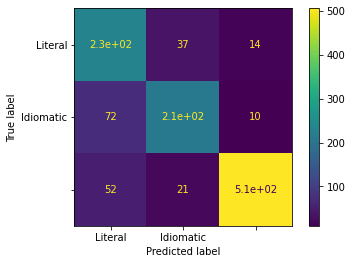

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test_vnc, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

In [ ]:
preds_vnc = model_vnc.predict({'input1': tokens_test_vnc, 'input2': contexts_test_vnc})
f1_score(np.argmax(preds_vnc, axis=1), np.argmax(Y_test_vnc, axis=1), average='micro')

0.8379549393414212

In [ ]:
preds_vnc = model_vnc.predict({'input1': tokens_test_vnc, 'input2': contexts_test_vnc})
f1_score(np.argmax(preds_vnc, axis=1), np.argmax(Y_test_vnc, axis=1), average='macro')

0.8170743932512124

In [ ]:
preds_vnc = model_vnc.predict({'input1': tokens_test_vnc, 'input2': contexts_test_vnc})
f1_score(np.argmax(preds_vnc, axis=1), np.argmax(Y_test_vnc, axis=1), average='weighted')

0.8374484670151875

## ANC

In [ ]:
contexts_tokenized_anc = data_anc.Context.apply(tokenize)
embedded_contexts_anc = get_embeddings(contexts_tokenized_anc)
tokens_anc = data_anc.Token.apply(tokenize)
embedded_tokens_anc = get_embeddings(tokens_anc, padded_size=30)

In [ ]:
labels_anc = to_categorical(data_anc.Label)
tokens_train_anc, tokens_test_anc = train_test_split(embedded_tokens_anc, test_size=0.3, random_state=34)
contexts_train_anc, contexts_test_anc = train_test_split(embedded_contexts_anc, test_size=0.3, random_state=34)
Y_train_anc, Y_test_anc = train_test_split(labels_anc, test_size=0.3, random_state=34)
tokens_train_anc = tf.convert_to_tensor(tokens_train_anc)
tokens_test_anc = tf.convert_to_tensor(tokens_test_anc)
contexts_train_anc = tf.convert_to_tensor(contexts_train_anc)
contexts_test_anc = tf.convert_to_tensor(contexts_test_anc)

### Classifier

In [ ]:
model_anc = build_model()

In [ ]:
model_anc.fit({'input1': tokens_train_anc, 'input2': contexts_train_anc}, 
               {'output': Y_train_anc}, batch_size=8, epochs=10)

Epoch 1/10
223/223 [==============================] - 37s 129ms/step - loss: 0.6197 - accuracy: 0.4843
Epoch 2/10
223/223 [==============================] - 26s 118ms/step - loss: 0.6079 - accuracy: 0.4949
Epoch 3/10
223/223 [==============================] - 26s 118ms/step - loss: 0.6083 - accuracy: 0.4949
Epoch 4/10
223/223 [==============================] - 26s 118ms/step - loss: 0.6081 - accuracy: 0.4949
Epoch 5/10
223/223 [==============================] - 26s 118ms/step - loss: 0.6077 - accuracy: 0.4949
Epoch 6/10
223/223 [==============================] - 27s 119ms/step - loss: 0.6085 - accuracy: 0.4949
Epoch 7/10
223/223 [==============================] - 26s 118ms/step - loss: 0.6082 - accuracy: 0.4949
Epoch 8/10
223/223 [==============================] - 26s 117ms/step - loss: 0.6081 - accuracy: 0.4949
Epoch 9/10
223/223 [==============================] - 27s 122ms/step - loss: 0.6082 - accuracy: 0.4949
Epoch 10/10
223/223 [==============================] - 27s 123ms/step - l

In [ ]:
model_anc.evaluate({'input1': tokens_test_anc, 'input2': contexts_test_anc}, 
               {'output': Y_test_anc})

24/24 [==============================] - 3s 50ms/step - loss: 0.6041 - accuracy: 0.5118


[0.6041263341903687, 0.5118110179901123]

In [ ]:
preds_anc = model_anc.predict({'input1': tokens_test_anc, 'input2': contexts_test_anc})
f1_score(np.argmax(preds_anc, axis=1), np.argmax(Y_test_anc, axis=1), average='micro')

0.5118110236220472

In [ ]:
f1_score(np.argmax(preds_anc, axis=1), np.argmax(Y_test_anc, axis=1), average='macro')

0.22569444444444445

In [ ]:
f1_score(np.argmax(preds_anc, axis=1), np.argmax(Y_test_anc, axis=1), average='weighted')

0.6770833333333334

In [ ]:
 n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_anc[:, i], preds_anc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
roc_auc

{0: 0.5, 1: 0.5, 2: 0.5}

[[  0   0 184]
 [  0   0 188]
 [  0   0 390]]


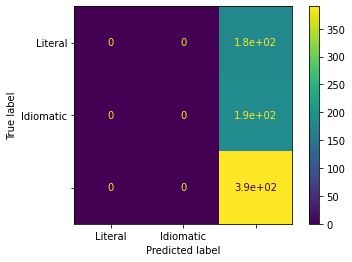

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test_anc, axis=1), np.argmax(preds_anc, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()